In [1]:
import math
import joblib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import qutip
from tqdm import tqdm

In [2]:
import sys
import pathlib

sys.path.append(str(pathlib.Path(sys.path[0]).parent / "libs"))

In [3]:
%reload_ext autoreload
%autoreload 2

import bec
import entanglement_propagation
from tools.jupyter import print_model_info
from tools.qutip import TqdmProgressBar

In [4]:
n_jobs = 1

## Проверка гамильтониана $ \sum S^z_jS^z_{j+1} \sim 4 \sum n^a_{j}n^a_{j+1} $

In [5]:
n_bosons = 5
model = bec.BEC_Qubits.init_default(n_bosons, 0)

m = 3
i_projection = n_bosons

print_model_info(model)

BEC_Qubits(n_bosons=5, coupling_strength=1, transition_ampl=1, transition_freq=11, resonance_freq=1, phase=0, excitation_level=False, communication_line=False)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
init_state = (
    # np.prod([bec.coherent_state_constructor(model, n=m, k=i) for i in range(m)]) # 100x slowly 
    math.prod(bec.coherent_state_constructor(model, n=m, k=i) for i in range(m)) 
    * bec.vacuum_state(model, n=m)
)

In [7]:
%time h_zz = sum(bec.sz(model, n=m, k=i) * bec.sz(model, n=m, k=i+1) for i in range(m - 1))

CPU times: user 15 ms, sys: 1.58 ms, total: 16.6 ms
Wall time: 16.1 ms


In [8]:
%time h_na = 4 * sum((-1)**i * bec.na(model, n=m, k=i) * bec.na(model, n=m, k=i+1) for i in range(m - 1))

CPU times: user 7.8 ms, sys: 1.38 ms, total: 9.19 ms
Wall time: 8.51 ms


In [9]:
tspan = np.linspace(0, np.pi / 4, 301)

In [10]:
%time states_hzz_n2_teor = [bec.state_under_h_zz_teor(model, t / model.Omega) for t in tqdm(tspan)]

100%|██████████| 301/301 [00:02<00:00, 124.15it/s]

CPU times: user 2.39 s, sys: 56.2 ms, total: 2.45 s
Wall time: 2.43 s


In [11]:
states_hzz_n3 = qutip.sesolve(h_zz, init_state, tspan, progress_bar=TqdmProgressBar()).states

/Users/kephircheek/venvs/science/emqwuqoc-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 301/301 [00:03<00:00, 82.52it/s]


In [12]:
states_hna_n3 = qutip.sesolve(h_na, init_state, tspan, progress_bar=TqdmProgressBar()).states

100%|██████████| 301/301 [00:03<00:00, 75.67it/s]


Редукция вместо измерения

In [13]:
states_hzz_n3_reduced = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(lambda x: qutip.ptrace(x, [0, 1, m*2 - 2, m*2 - 1]))(s) 
    for s in tqdm(states_hzz_n3)
)

100%|██████████| 301/301 [00:07<00:00, 42.84it/s]


Создаем проектор для измерения и проводим измерение

In [14]:
measure_x = bec.fock_x_state_constructor(model, n=m, i=1, k=i_projection) #* bec.vacuum_state(model, n=n)
measure_x_op = measure_x * measure_x.dag()

def measure(state, operators):
    dim = len(states_hzz_n3[0].dims[0])
    mesuare_x_op = operators[0]
    state_mesuared_unnormalized = qutip.ptrace(mesuare_x_op * state, [0, 1, dim - 2, dim - 1])
    return state_mesuared_unnormalized / state_mesuared_unnormalized.tr()

In [15]:
states_hzz_n3_mesuared_by_x = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(measure)(s, [measure_x_op]) for s in tqdm(states_hzz_n3)
)

100%|██████████| 301/301 [00:07<00:00, 41.72it/s]


In [16]:
states_hna_n3_mesuared_by_x = joblib.Parallel(n_jobs=n_jobs)( 
    joblib.delayed(measure)(s, [measure_x_op]) for s in tqdm(states_hna_n3)
)

100%|██████████| 301/301 [00:07<00:00, 41.63it/s]


### Энтропия 

In [17]:
entropy_hzz_n2_teor = [qutip.entropy.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) for s in tqdm(states_hzz_n2_teor)]
entropy_hzz_n3 = [qutip.entropy.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) for s in tqdm(states_hzz_n3_reduced)]
entropy_hzz_n3_x = [entanglement_propagation.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) for s in tqdm(states_hzz_n3_mesuared_by_x)]
entropy_hna_n3_x = [entanglement_propagation.entropy_vn(qutip.ptrace(s, [0, 1]), base=2) for s in tqdm(states_hna_n3_mesuared_by_x)]

100%|██████████| 301/301 [00:00<00:00, 704.61it/s]


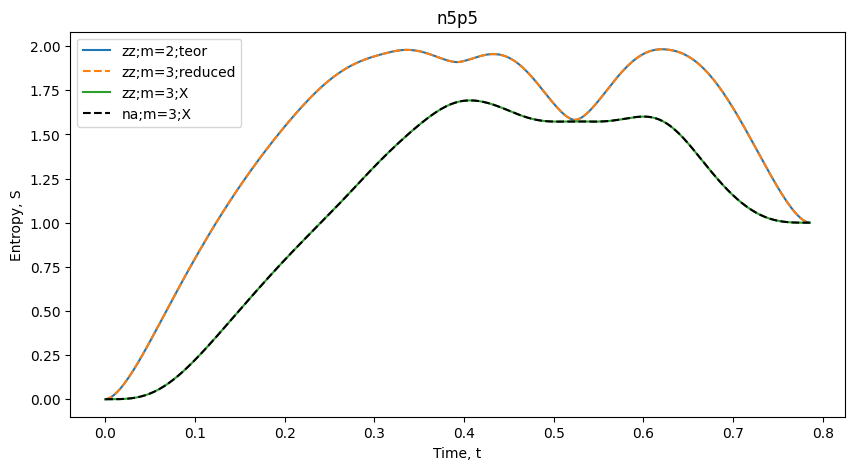

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, entropy_hzz_n2_teor, label=f"zz;m=2;teor")
ax.plot(tspan, entropy_hzz_n3, "--", label=f"zz;m={m};reduced")
ax.plot(tspan, entropy_hzz_n3_x, "-", label=f"zz;m={m};X")
ax.plot(tspan, entropy_hna_n3_x, "--k", label=f"na;m={m};X")

ax.set_title(f"n{n_bosons}p{i_projection}")
ax.set_ylabel("Entropy, S")
ax.set_xlabel("Time, t")
ax.legend()

Энтропия действительно совпадает 

### Фиделити

In [19]:
fids_hzz_n3_reduced = [
    qutip.metrics.fidelity(a, b) 
    for a, b in tqdm(
        zip(states_hzz_n2_teor, states_hzz_n3_reduced),
        total=len(states_hzz_n2_teor)
    )
]

100%|██████████| 301/301 [00:06<00:00, 45.44it/s]


In [20]:
fids_hzz_n3_mesuared_by_x = [
    qutip.metrics.fidelity(a, b) 
    for a, b in tqdm(
        zip(states_hzz_n2_teor, states_hzz_n3_mesuared_by_x),
        total=len(states_hzz_n2_teor)
    )
]

100%|██████████| 301/301 [00:06<00:00, 45.29it/s]


In [21]:
fids_hna_n3_mesuared_by_x = [
    qutip.metrics.fidelity(a, b) 
    for a, b in tqdm(
        zip(states_hzz_n2_teor, states_hna_n3_mesuared_by_x),
        total=len(states_hzz_n2_teor)
    )
]

100%|██████████| 301/301 [00:06<00:00, 45.59it/s]


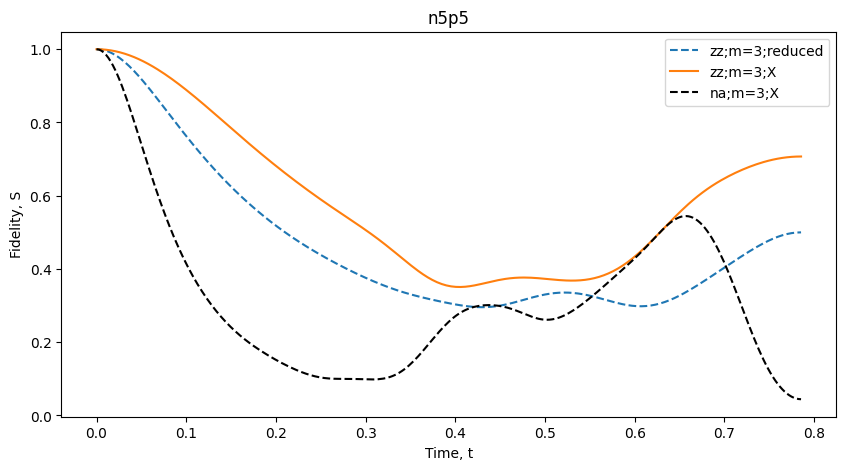

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(tspan, fids_hzz_n3_reduced, "--", label=f"zz;m={m};reduced")
ax.plot(tspan, fids_hzz_n3_mesuared_by_x, "-", label=f"zz;m={m};X")
ax.plot(tspan, fids_hna_n3_mesuared_by_x, "--k", label=f"na;m={m};X")

ax.set_title(f"n{n_bosons}p{i_projection}")
ax.set_ylabel("Fidelity, S")
ax.set_xlabel("Time, t")
ax.legend()